<a href="https://colab.research.google.com/github/redman157/HocML/blob/master/colaborative-filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pson2809","key":"f045f4a4adb9707f5c86d18bc28608b2"}'}

In [2]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 64 Mar  4 22:41 kaggle.json


In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# List available datasets.
!kaggle datasets list

ref                                                          title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
ronitf/heart-disease-uci                                     Heart Disease UCI                                     3KB  2018-06-25 11:33:56          12209  
russellyates88/suicide-rates-overview-1985-to-2016           Suicide Rates Overview 1985 to 2016                 396KB  2018-12-01 19:18:25           8618  
karangadiya/fifa19                                           FIFA 19 complete player dataset                       2MB  2018-12-21 03:52:59          11488  
iarunava/cell-images-for-detecting-malaria                   Malaria Cell Images Dataset                         337MB  2018-12-05 05:40:21           2153  
mohansacharya/graduate-admissions                         

In [6]:
!kaggle datasets download -d rounakbanik/the-movies-dataset
!kaggle datasets download -d tmdb/tmdb-movie-metadata

 97% 222M/228M [00:02<00:00, 75.3MB/s]
100% 228M/228M [00:02<00:00, 98.6MB/s]
 54% 5.00M/9.30M [00:00<00:00, 45.3MB/s]
100% 9.30M/9.30M [00:00<00:00, 59.2MB/s]


In [7]:
!unzip the-movies-dataset.zip

Archive:  the-movies-dataset.zip
  inflating: ratings.csv             
  inflating: ratings_small.csv       
  inflating: links.csv               
  inflating: links_small.csv         
  inflating: keywords.csv            
  inflating: movies_metadata.csv     
  inflating: credits.csv             


In [8]:
!unzip tmdb-movie-metadata.zip

Archive:  tmdb-movie-metadata.zip
  inflating: tmdb_5000_credits.csv   
  inflating: tmdb_5000_movies.csv    


In [15]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

df1 = pd.read_csv('movies_metadata.csv')
df2 = pd.read_csv('ratings.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
!sudo pip install scikit-surprise

In [0]:
cols = ["id","title"]
df1 = df1[cols]

In [0]:
df = pd.concat([df1,df2],axis = 1 )

In [0]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())

In [45]:
ratings['number_of_ratings'] = df.groupby('title')['rating'].count()
ratings.number_of_ratings.unique()

array([ 1,  2,  4,  3,  7,  6,  9,  5,  8, 11])

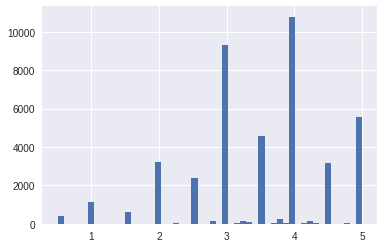

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
ratings['rating'].hist(bins=50)


In [43]:
df.head(5)

,id,title,userId,movieId,rating,timestamp
0,862,Toy Story,1,110,1.0,1425941529
1,8844,Jumanji,1,147,4.5,1425942435
2,15602,Grumpier Old Men,1,858,5.0,1425941523
3,31357,Waiting to Exhale,1,1221,5.0,1425941546
4,11862,Father of the Bride Part II,1,1246,5.0,1425941556


In [44]:
movie_matrix = df.pivot_table(index='userId', columns='title', values='rating')
movie_matrix.head()


title,!Women Art Revolution,#1 Cheerleader Camp,#Horror,#chicagoGirl,"$1,000 on the Black","$100,000 for Ringo",$5 a Day,$50K and a Call Girl: A Love Story,$9.99,$ellebrity,...,Путь к себе,Семь кабинок,Совершенно серьезно,Убить дракона,Юленька,هیچ کجا هیچ کس,‘Rameau’s Nephew’ by Diderot (Thanx to Dennis Young) by Wilma Schoen,’Round Midnight,…And the Fifth Horseman Is Fear,ファンタスティポ
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
ratings.sort_values('number_of_ratings', ascending=False).head(10)

,rating,number_of_ratings
title,,
Cinderella,4.136364,11
Alice in Wonderland,2.722222,9
Hamlet,3.500000,9
Les Misérables,2.937500,8
Beauty and the Beast,3.875000,8
The Three Musketeers,3.285714,7
Treasure Island,3.357143,7
Blackout,3.285714,7
A Christmas Carol,3.642857,7
